<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Заключение</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

Загрузим и посмотрим на данные

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим на дубликаты

In [3]:
print('Количество дубликатов: ', data.duplicated().sum())

Количество дубликатов:  0


Оценим пропуски

In [4]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

В категории Tenure 909 пропусков, здесь хранятся данные сколько лет человек является клиентом банка. Вероятно эти данные будут важны для нашего исследования. Посмотрим на их распределение.

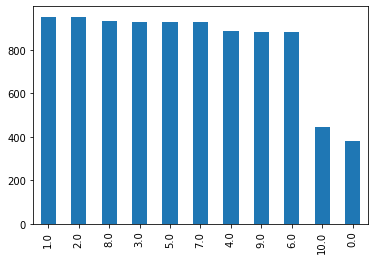

In [5]:
data.Tenure.value_counts().plot(kind='bar')

Заполним пропуски новым значением -1. Таким образом, мы сохраим данные о пропусках, что тоже может быть ценной информацией. 

In [6]:
data['Tenure'] = data['Tenure'].fillna(-1)
data.Tenure.isna().sum()

0

Выборка содержит категориальные и численные данные. Целевой признак Exited (факт ухода клиента) также относится к категориальному (значения 0 и 1), будет решаться задача бинарной классификации.

Некторые столбцы содержат данные которые вряд ли имеют связь с фактом оттока клиента из банка, в частоности это: RowNumber — индекс строки в данных, CustomerId — уникальный идентификатор клиента, Surname — фамилия. Удалим эти столбцы.

In [7]:
dt_clean = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
dt_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Посмотрим на уникальность и распределение данных в строковых столбцах Geography и Gender

In [8]:
display(dt_clean.Geography.value_counts())
display(dt_clean.Gender.value_counts())

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Male      5457
Female    4543
Name: Gender, dtype: int64

Количество уникальных значений небольшое, при использовании техники One-Hot Encoding для проеобразования категориальных данных таблица увеличится незначительно. На ней и остановимся - она работает со всеми моделями. Чтобы не попасть в дамми-ловушку, установим аргумент drop_first=True

In [9]:
data_ohe = pd.get_dummies(dt_clean, drop_first=True)
display(data_ohe.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [10]:
data_ohe.shape

(10000, 12)

Разобъем исходные данные на 3 выборки, обучающую, валидационную и тестовую, в соотношении 60:20:20 

In [11]:
data_train_valid, data_test = train_test_split(
                        data_ohe, test_size=0.20, random_state=12345)
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

target = data_train_valid['Exited']
features = data_train_valid.drop('Exited', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


Данные разделили. 

Чтобы не потерять значимость численных признаков из-за разности масштабов, стандартизируем их. Численные признаки у нас в столбцах: CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary

In [12]:
pd.options.mode.chained_assignment = None
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head())
display(features_valid.head())
display(features_test.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
492,-0.134048,-0.078068,-0.137323,0.076163,0.816929,0,1,0.331571,0,0,0
6655,-1.010798,0.494555,-1.661443,0.136391,-0.896909,1,1,-0.727858,0,0,1
4287,0.639554,1.353490,-1.051795,0.358435,-0.896909,1,1,-0.477006,1,0,1
42,-0.990168,2.116987,-0.746971,0.651725,-0.896909,1,1,-0.100232,0,0,0
8178,0.567351,0.685430,0.777149,0.813110,0.816929,1,1,0.801922,0,0,0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2358,0.175393,0.399118,-1.051795,1.385698,-0.896909,0,1,-1.466761,0,0,1
8463,-1.299609,0.971741,-0.746971,-1.232442,-0.896909,1,0,0.254415,0,1,1
163,0.711757,-0.268942,-0.746971,-1.232442,0.816929,1,1,0.122863,0,1,0
3074,-0.391916,0.494555,0.472325,0.672529,-0.896909,1,0,0.585847,1,0,0
5989,0.165078,1.353490,1.691621,0.536522,-0.896909,0,0,1.462457,0,0,0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7867,-0.123733,0.685430,-0.442147,-1.232442,-0.896909,1,1,0.980212,0,1,0
1402,1.083087,-0.937002,1.081973,0.858518,-0.896909,1,0,-0.390486,0,0,1
8606,1.598822,0.303681,0.167501,-1.232442,0.816929,1,1,-0.435169,0,1,1
8885,0.165078,0.589993,-0.137323,0.412100,0.816929,1,1,1.017079,0,1,1
6494,0.484834,-1.032439,0.777149,-1.232442,0.816929,1,1,-1.343558,0,0,1


Данные подготовлены, приступим к исследованию.

## Исследование задачи

Обучим на наших данных модели Дерево решений, Случайный лес, Логистческая регрессия и посмотрим на их качество - accuracy.

In [13]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predicted_valid_tree = model_tree.predict(features_valid)
accuracy_tree  = accuracy_score(target_valid, predicted_valid_tree)
print('Значение accuracy для дерева решений:', accuracy_tree)

model_forest = RandomForestClassifier(random_state=12345, n_estimators = 50)
model_forest.fit(features_train, target_train)
predicted_valid_forest = model_forest.predict(features_valid)
accuracy_forest  = accuracy_score(target_valid, predicted_valid_forest)
print('Значение accuracy для случайного леса:', accuracy_forest)

model_lr = LogisticRegression(random_state=12345, solver='lbfgs')
model_lr.fit(features_train, target_train)
predicted_valid_lr = model_lr.predict(features_valid)
accuracy_lr  = accuracy_score(target_valid, predicted_valid_lr)
print('Значение accuracy для логистической регрессии:', accuracy_lr)

Значение accuracy для дерева решений: 0.792
Значение accuracy для случайного леса: 0.8625
Значение accuracy для логистической регрессии: 0.8165


Все модели демонстрируют относительно высокие значения accuracy. Оценим их адекватность. Проверим, как часто в целевом признаке встречаются классы 1 и 0. 

0    0.7963
1    0.2037
Name: Exited, dtype: float64


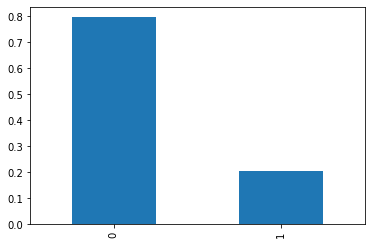

In [14]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Преобладает класс 0 в соотношении прмерно 80:20. Проверим частоты классов в результатах предсказаний наших моделей 

In [15]:
models_dict = {'Дерево решений':model_tree,
              'Случайный лес':model_forest,
              'Логистческая регрессия':model_lr}

models_predicted_valid = {'Дерево решений':predicted_valid_tree,
              'Случайный лес':predicted_valid_forest,
              'Логистческая регрессия':predicted_valid_lr}

for key in models_predicted_valid:
    print(key)
    print(pd.Series(models_predicted_valid[key]).value_counts(normalize=True))
    print()

Дерево решений
0    0.7955
1    0.2045
dtype: float64

Случайный лес
0    0.881
1    0.119
dtype: float64

Логистческая регрессия
0    0.93
1    0.07
dtype: float64



Ожидаемо результаты предсказаний моделей сильно склоняются к предсказанию одного класса, '0' пеобладает, особенно выделяется логистическая регрессия - 93% таких предсказаний.
Сравним с константной моделью, в качестве прогнозного значения константной модели выберем '0'.  

In [16]:
target_pred_constant = pd.Series(0, index=target_valid.index)
accuracy_score(target_pred_constant, target_valid)

0.8045

Точность модели Дерево решений ниже константной, остальные модели выглядят адекватными, но их accuracy близки к константной модели. Вероятно на обучении моделей сказыватся дисбаланс классов.
Построим матрицы ошибок для предсказаний наших моделей. Рассчитаем метрики Recall, Precision, F1, AUC-ROC и построим ROC-кривые.

***Дерево решений***
Матрица ошибок:
[[1392  217]
 [ 199  192]]
Recall: 0.49104859335038364
Precision: 0.46943765281173594
F1: 0.48000000000000004
AUC-ROC: 0.6780911083594678



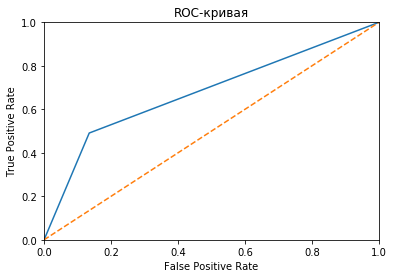


***Случайный лес***
Матрица ошибок:
[[1548   61]
 [ 214  177]]
Recall: 0.45268542199488493
Precision: 0.7436974789915967
F1: 0.5627980922098569
AUC-ROC: 0.8422571882267107



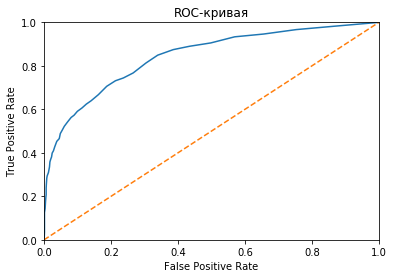


***Логистческая регрессия***
Матрица ошибок:
[[1551   58]
 [ 309   82]]
Recall: 0.20971867007672634
Precision: 0.5857142857142857
F1: 0.30885122410546145
AUC-ROC: 0.7707715074572536



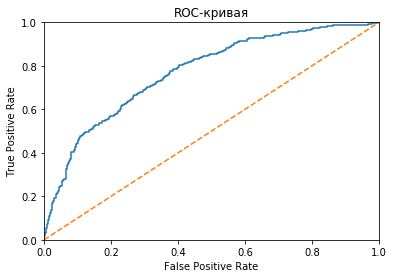

In [17]:
for key in models_predicted_valid:
    print('***' + key + '***')
    print('Матрица ошибок:')
    print(confusion_matrix(target_valid, models_predicted_valid[key]))
    print('Recall:', recall_score(target_valid, models_predicted_valid[key]))
    print('Precision:', precision_score(target_valid, models_predicted_valid[key]))
    print('F1:', f1_score(target_valid, models_predicted_valid[key]))
        
    probabilities_one_valid = models_dict[key].predict_proba(features_valid)[:, 1]
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))
    print()
    
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0]) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()
    print()

Все модели имеют высокие значения негативных ответов, что объясняется дисбалансом в пользу 0 класса.  
Логистическая регрессия демонстрирует низкую метрику F1=0.31, полнота 0.21 при точности 0.59. Модель склонна к негативным ответам и имеет большое количество ложно-негативных предсказаний.  
Дерево решений - метрика F1=0.48, выше чем у логистической регрессии, полнота также выше - 0.49, при этом точноть ниже - 0.47. Помимо склонности к негативным ответам, у модели много ложно-позитивных предсказаний.  
Случайный лес - лучший результат метрики F1=0.56 и высокая точность 0.74. Ни одна модель не достигает необходимого уровня F1-меры 0.59. Необходимо улучшение качества моделей с учетом выявленного дисбаланса классов.

## Борьба с дисбалансом

Попробуем применить взвешивание классов 

In [18]:
model_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree.fit(features_train, target_train)
predicted_valid_tree = model_tree.predict(features_valid)
print('Значение F1 для дерева решений:', f1_score(target_valid, predicted_valid_tree))

model_forest = RandomForestClassifier(random_state=12345, n_estimators = 50, class_weight='balanced')
model_forest.fit(features_train, target_train)
predicted_valid_forest = model_forest.predict(features_valid)
print('Значение F1 для случайного леса:', f1_score(target_valid, predicted_valid_forest))

model_lr = LogisticRegression(random_state=12345, solver='lbfgs', class_weight='balanced')
model_lr.fit(features_train, target_train)
predicted_valid_lr = model_lr.predict(features_valid)
print('Значение F1 для логистической регрессии:', f1_score(target_valid, predicted_valid_lr))

Значение F1 для дерева решений: 0.4605263157894737
Значение F1 для случайного леса: 0.5517241379310345
Значение F1 для логистической регрессии: 0.47763864042933807


F1-мера улучшилась только для модели логистической регрессии, остальные показали результат хуже предыдущего. Нужны другие методы борьбы с дисбалансом. 
Применим метод балансировки данных - upsampling. Применим для этого функцию

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Проверим соотношение классов 0 и 1 в обучающей выборке

0    0.796833
1    0.203167
Name: Exited, dtype: float64


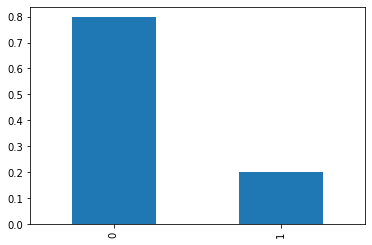

In [20]:
class_frequency = target_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Увеличим класс 1 в 4 раза и проверим полученное соотношение классов

1    0.504919
0    0.495081
Name: Exited, dtype: float64


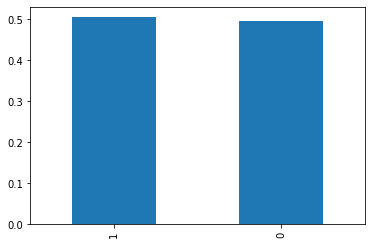

In [21]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Обучим модель на новой выборке и проверим значение F1-меры. Используем метод Случайного леса, как ниаболее перспективный по итогам предыдущих исследований.

In [22]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators = 50)
model_forest.fit(features_upsampled, target_upsampled)
predicted_valid_forest = model_forest.predict(features_valid)
print('Значение F1 для случайного леса:', f1_score(target_valid, predicted_valid_forest))

Значение F1 для случайного леса: 0.6013986013986015


F1-мера выросла и превысила целевое значение 0.59. Проверим поведение модели при применении downsampling. 

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Уменьшим класс 0 в 4 раза и проверим полученное соотношение классов

1    0.504971
0    0.495029
Name: Exited, dtype: float64


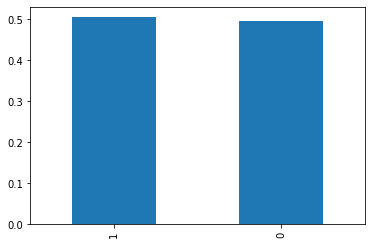

In [24]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Обучим модель на новой выборке и проверим значение F1-меры.

In [25]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators = 50)
model_forest.fit(features_downsampled, target_downsampled)
predicted_valid_forest = model_forest.predict(features_valid)
print('Значение F1 для случайного леса:', f1_score(target_valid, predicted_valid_forest))

Значение F1 для случайного леса: 0.5450980392156862


Результат модели обученной на данных features_upsampled был выше, эти данные и оставим для обучения. Попробуем еще улучшить модель путем изменения гиперпараметров глубины и количества деревьев при обучении модели и подбора коэффициента увеличения выборки.

In [26]:
%%time
best_model = None
best_result_f1 = 0
best_est = 0
best_depth = 0
best_repeat = 0

for repeat in range (2, 5):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    for est in range(3, 50, 4):
        for depth in range (2, 15, 2):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
            model.fit(features_upsampled, target_upsampled)
            predictions_valid = model.predict(features_valid)
            result = f1_score(target_valid, predictions_valid)
        
            if result > best_result_f1:
                best_model = model
                best_result_f1 = result
                best_est = est
                best_depth = depth
                best_repeat = repeat

print("F1 наилучшей модели на валидационной выборке:", best_result_f1)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", best_depth)
print("Коэффициент увеличения выборки:", best_repeat)

F1 наилучшей модели на валидационной выборке: 0.61212976022567
Количество деревьев: 39
Максимальная глубина: 12
Коэффициент увеличения выборки: 2
CPU times: user 36.7 s, sys: 50 ms, total: 36.7 s
Wall time: 37 s


На лучшей модели F1-метрика достигла значения 0.612, что выше целевого значения 0.59. Перейдем к тестированию нашей модели.

## Тестирование модели

Проверим работу модели на тестовых данных, замерим F1-меру

In [27]:
predictions_test = best_model.predict(features_test)
print('F1 на тестовых данных:', f1_score(target_test, predictions_test))

F1 на тестовых данных: 0.6092715231788078


Результат на тестовых данных превышает целевое значение 0.59. Посмотрим еще на полноту и точность нашей модели.

In [28]:
print('Recall:', recall_score(target_test, predictions_test))
print('Precision:', precision_score(target_test, predictions_test))

Recall: 0.5386416861826698
Precision: 0.7012195121951219


Модель находит больше половины положительных объектов при точности 0.701. Проверим ее на адекватность, сравним accuracy с константной моделью, рассчиатем AUC-ROC и построим ROC-кривую

In [29]:
print('Accuracy лучшей модели:', accuracy_score(target_test, predictions_test))
target_pred_constant = pd.Series(0, index=target_valid.index)
print('Accuracy константной модели:', accuracy_score(target_pred_constant, target_test))
print()
    
probabilities_one_valid = model.predict_proba(features_test)[:, 1]
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_valid))

Accuracy лучшей модели: 0.8525
Accuracy константной модели: 0.7865

AUC-ROC: 0.8475555740831449


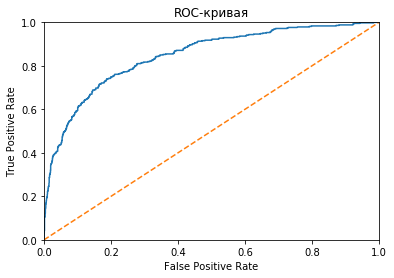

In [30]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Accuracy нашей модели выше константной, AUC-ROC=0.85, для случайной модели это 0.5. Можно считать нашу модель адекватной.

## Заключение

Для решения поставленной задачи, были исследованы данные оттока клиентов банка. Исследование показало, что данные были несбалансированы - преобладал класс 0 в соотношении прмерно 80:20, имелись пропуски. Обучение моделей Дерево решений, Случайный лес и Логистческая регрессия на изначальных данных не позволило достичь целевого показателя F1. Для борьбы с дисбалнсом был применен метод upsampling и для метода Случайного леса были подобраны гиперпараметры estimators и depth. Лучшие результаты были получены при увеличении в обучающей выборке положительного класса в 2 раза до образования соотношения классов 0 и 1 как 2:1. Итоговая модель показала F1-меру на тестовых данных 0.601, AUC-ROC 0.848. Модель прошла проверку на адекватность.